In [1]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 4.6 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
import yfinance as yf

data = yf.download("FDTR", start='2018-01-01', end='2021-12-01')
print (data.head())


[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FDTR: No data found for this date range, symbol may be delisted
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []


Fundamentals are data having to do with the asset issuer, like the sector, size, and expenses of the company. We can use this data to build a linear factor model, expressing the returns as

$$R_i = a_i + b_{i1} F_1 + b_{i2} F_2 + \ldots + b_{iK} F_K + \epsilon_i$$
There are two different approaches to computing the factors $F_j$, which represent the returns associated with some fundamental characteristics, and the factor sensitivities $b_{ij}$.

## Approach 1: Portfolio Construction
In the first, we start by representing each characteristic of interest by a portfolio: we sort all assets by that characteristic, then build the portfolio by going long the top quantile of assets and short the bottom quantile. The factor corresponding to this characteristic is the return on this portfolio. Then, the $b_{ij}$ are estimated for each asset $i$ by regressing over the historical values of $R_i$ and of the factors.

We'll use the canonical Fama-French factors for this example, which are the returns of portfolios constructred based on fundamental factors.

We start by getting the fundamentals data for all assets and constructing the portfolios for each characteristic:

In [ ]:
import sys
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/finance_course/Projects')

Mounted at /content/drive


In [ ]:
import pandas as pd

data = pd.read_csv("/content/drive/MyDrive/finance_course/Projects/bbg.csv", index_col="Date")
market = pd.read_csv("/content/drive/MyDrive/finance_course/Projects/market.csv", index_col="Date")

print (data.head())

            Unnamed: 0 ticker  Adj Close    return  CUR_MKT_CAP       BoP
Date                                                                     
2019-01-03           1     GE  61.300621  0.001241   70106.8069  0.459411
2019-01-04           2     GE  62.593567  0.020873   71585.4864  0.449924
2019-01-07           3     GE  66.472382  0.060124   76021.5251  0.423675
2019-01-08           4     GE  65.103378 -0.020810   74455.8644  0.432582
2019-01-09           5     GE  64.647049 -0.007034   73933.9775  0.435635


In [ ]:
print (market.head())

             Open_SP500   High_SP500  ...  return_Rf        f3
Date                                  ...                     
2019-01-02  2476.959961  2519.489990  ...        NaN       NaN
2019-01-03  2491.919922  2493.139893  ...  -0.004237 -0.020831
2019-01-04  2474.330078  2538.070068  ...   0.001273  0.032486
2019-01-07  2535.610107  2566.159912  ...  -0.002123  0.009109
2019-01-08  2568.110107  2579.820068  ...   0.019778 -0.010129

[5 rows x 15 columns]


In [ ]:
market['f3'] = market['return_SP500'] - market['Adj Close_Rf']
market.to_csv("/content/drive/MyDrive/finance_course/Projects/market.csv")

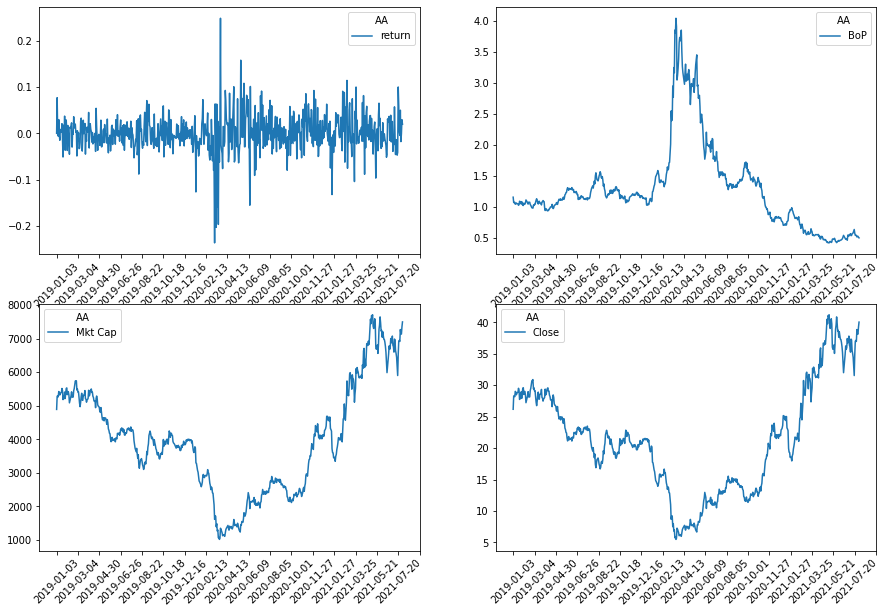

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (15, 10)

ticker = "AA"

temp = data[data['ticker'] == ticker]
sub1 = plt.subplot(2, 2, 1)
sub1.plot(temp.index, temp['return'], label="return")
sub1.xaxis.set_major_locator(plt.MaxNLocator(20))
sub1.tick_params(axis='x', labelrotation = 45)
sub1.legend(title=ticker)

sub2 = plt.subplot(2, 2, 2)
sub2.plot(temp.index, temp['BoP'], label="BoP")
sub2.xaxis.set_major_locator(plt.MaxNLocator(20))
sub2.tick_params(axis='x', labelrotation = 45)
sub2.legend(title=ticker)

sub3 = plt.subplot(2, 2, 3)
sub3.plot(temp.index, temp['CUR_MKT_CAP'], label="Mkt Cap")
sub3.xaxis.set_major_locator(plt.MaxNLocator(20))
sub3.tick_params(axis='x', labelrotation = 45)
sub3.legend(title=ticker)

sub3 = plt.subplot(2, 2, 4)
sub3.plot(temp.index, temp['Adj Close'], label="Close")
sub3.xaxis.set_major_locator(plt.MaxNLocator(20))
sub3.tick_params(axis='x', labelrotation = 45)
sub3.legend(title=ticker)

plt.show()

In [ ]:
f1_list = []
for d in sorted(set(data.index)):
  temp = data.loc[data.index == d]
  market_cap_top = temp.sort_values('CUR_MKT_CAP')[7*len(temp)//10:]
  market_cap_bottom = temp.sort_values('CUR_MKT_CAP')[:3*len(temp)//10]

  f1_list.append({'Date':d, "f1":market_cap_top['return'].mean() - market_cap_bottom['return'].mean()})

f1 = pd.DataFrame(f1_list)
f1 = f1.set_index('Date')

In [ ]:
f2_list = []
for d in sorted(set(data.index)):
  temp = data.loc[data.index == d]
  bp_top = temp.sort_values('BoP')[7*len(temp)//10:]
  bp_bottom = temp.sort_values('BoP')[:3*len(temp)//10]

  f2_list.append({'Date':d, "f2":bp_top['return'].mean() - bp_bottom['return'].mean()})

f2 = pd.DataFrame(f2_list)
f2 = f2.set_index('Date')

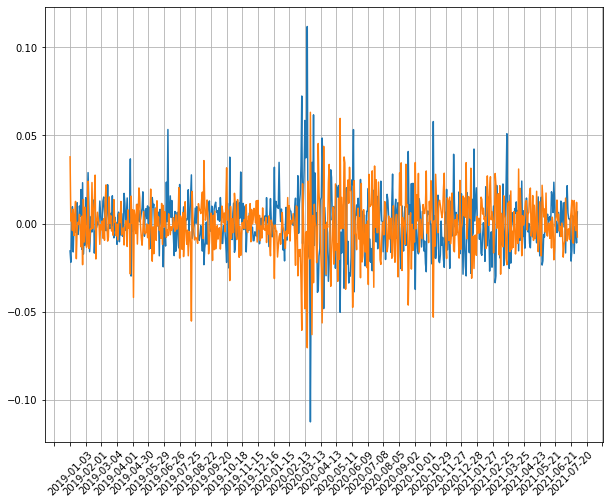

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams 

rcParams['figure.figsize'] = (10, 8)

fig, ax = plt.subplots()
ax.plot(f1.index, f1['f1'], label="f1 (BoP)")
ax.plot(f2.index, f2['f2'], label="f2 (Mkt Cap)")

ax.xaxis.set_major_locator(plt.MaxNLocator(40))
ax.tick_params(axis='x', labelrotation = 45)
plt.grid(True)
plt.show()

Now that we have returns series representing our factors, we can compute the factor model for any return stream using a linear regression. Below, we compute the factor sensitivities for returns on Alcoa stock:

In [ ]:
import statsmodels.api as sm
import numpy as np

window = 60
tickers = data['ticker'].unique()
results = {}
residuals = {}

for t in tickers:
  asset = data.loc[data['ticker'] == t]
  asset = asset.join(f1, on="Date")
  asset = asset.join(f2, on="Date")
  asset = asset.join(market, on='Date')
  asset.dropna(inplace=True)
  #mlr = sm.OLS(asset['return'], sm.add_constant(np.column_stack((asset['f1'], asset['f2'])))).fit()

  #print ('Historical sensitivities of {} returns to factors:\nMarket cap: {:.3f}\nB/P: {:.3f}'.format(t, 
  #                                                                                                    mlr.params[1],
  #                                                                                                    mlr.params[2]))
  
  #print ('\nValues of factors on {}:\nMarket cap: {:.3f}\nB/P: {:.3f}'.format(
  #    asset.index[-1],
  #    asset['f1'].iloc[-1], 
  #    asset['f2'].iloc[-1]))

  temp_result = []
  temp_residuals = []
  x = []
  for i in range(0, len(asset)-window):
    x.append(asset.index[i])
    temp = asset.iloc[i:i+window, :]
    r = sm.OLS(temp['return'], sm.add_constant(temp[['f1', 'f2', 'f3']])).fit()
    temp_result.append(r.params)
    temp_residuals.append(r.resid.var())
    #print (r.summary())
  results[t] = np.array(temp_result)
  residuals[t] = np.array(temp_residuals)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


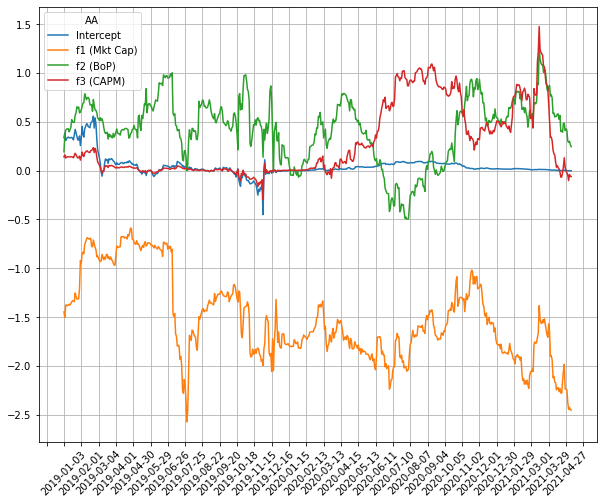

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (10, 8)
ticker = "AA"

fig, ax = plt.subplots()
ax.plot(x, results[ticker][:, 0], label="Intercept")
ax.plot(x, results[ticker][:, 1], label="f1 (Mkt Cap)")
ax.plot(x, results[ticker][:, 2], label="f2 (BoP)")
ax.plot(x, results[ticker][:, 3], label="f3 (CAPM)")

ax.xaxis.set_major_locator(plt.MaxNLocator(40))
ax.tick_params(axis='x', labelrotation = 45)
plt.grid(True)

plt.legend(title=ticker)
plt.show()

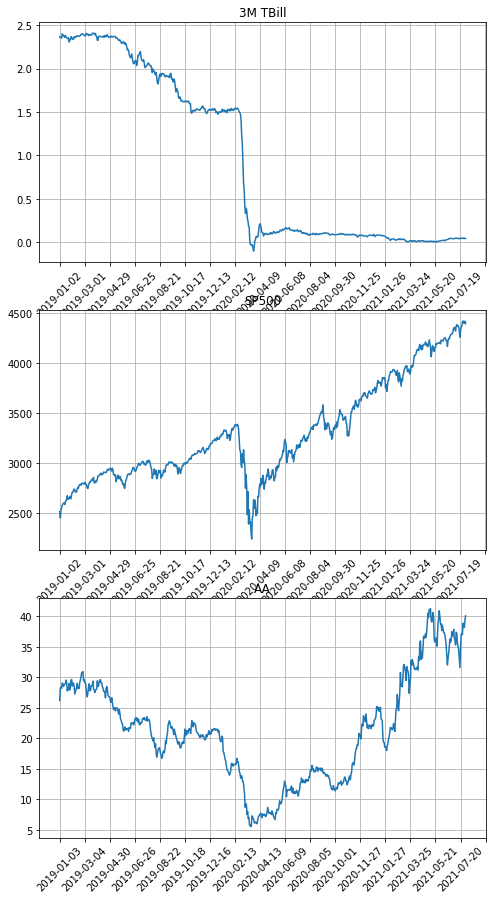

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (8, 15)
sub1 = plt.subplot(3, 1, 1)
sub1.plot(market.index, market['Adj Close_Rf'])
sub1.set_title("3M TBill")
sub1.xaxis.set_major_locator(plt.MaxNLocator(20))
sub1.tick_params(axis='x', labelrotation = 45)
sub1.grid(True)

sub2 = plt.subplot(3, 1, 2)
sub2.plot(market.index, market['Adj Close_SP500'])
sub2.set_title("SP500")
sub2.xaxis.set_major_locator(plt.MaxNLocator(20))
sub2.tick_params(axis='x', labelrotation = 45)
sub2.grid(True)

sub3 = plt.subplot(3, 1, 3)
sub3.plot(data[data['ticker'] == "AA"].index, data['Adj Close'].loc[data['ticker'] == "AA"])
sub3.set_title("AA")
sub3.xaxis.set_major_locator(plt.MaxNLocator(20))
sub3.tick_params(axis='x', labelrotation = 45)
sub3.grid(True)

plt.show()

In [ ]:
# Sanity check
t = 'AAPL'
asset = data.loc[data['ticker'] == t]
asset = asset.join(f1, on="Date")
asset = asset.join(f2, on="Date")
asset = asset.join(market, on='Date')

asset.dropna(inplace=True)

temp_result = []
temp_residuals = []
x = []
for i in range(0, len(asset)-window):
  x.append(asset.index[i])
  temp = asset.iloc[i:i+window, :]
  r = sm.OLS(temp['return_SP500'], sm.add_constant(temp[['f1', 'f2', 'return_SP500']])).fit()
  temp_result.append(r.params)
  temp_residuals.append(r.resid.var())
results['SP500'] = np.array(temp_result)
residuals['SP500'] = np.array(temp_residuals)

## Splitting Variance into Common Factor Risks
The portfolio variance can be represented as:

$$\sigma^2 = \omega BVB^{\top}\omega^{\top} + \omega D\omega^{\top}$$

where:

$$\begin{eqnarray} B &=& \text{the matrix of factor exposures of $n$ assets to the factors} \\ V &=& \text{the covariance matrix of factors} \\ D &=& \text{the specific variance} \\ \omega &=& \text{the vector of portfolio weights for $n$ assets}\\ \omega BVB^{\top}\omega^{\top} &=& \text{common factor variance} \\ \omega D\omega^{\top} &=& \text{specific variance} \\ \end{eqnarray}$$

### Computing Common Factor and Specific Variance
Here we build functions to break out the risk in our portfolio. Suppose that our portfolio consists of all stocks in the input file, equally-weighted. Let's have a look at how much of the variance of the returns in this universe are due to common factor risk.

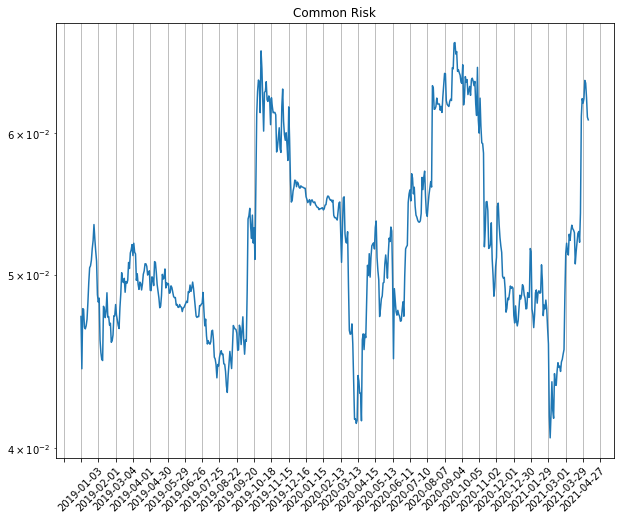

In [ ]:
rcParams['figure.figsize'] = (10, 8)
w = np.array([1/len(tickers)]*len(tickers))

# use just factors in dates where regression is done
factors = f1.loc[x].join(f2, on="Date")
factors = factors.join(market['f3'], on="Date")
#F = np.asarray(factors)
V = factors.cov()

Sigma = []
for ix in range(len(x)):
  B = np.zeros(shape=(len(tickers), 3))
  for it, t in enumerate(tickers):
    B[it, :] = results[t][ix, 1:]
  
  Sigma.append(w.dot(B).dot(V).dot(B.T).dot(w.T))
Sigma = np.array(Sigma)

fig, ax = plt.subplots()
ax.plot(x, Sigma)
ax.xaxis.set_major_locator(plt.MaxNLocator(40))
ax.tick_params(axis='x', labelrotation = 45)
plt.grid(True)
plt.yscale("log")
plt.title("Common Risk")
plt.show()

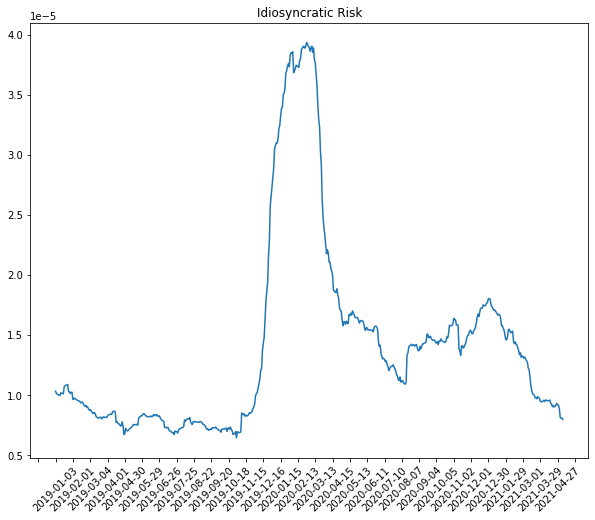

In [ ]:
Delta = []

for ix in range(len(x)): 
  epsilon = np.zeros(shape=(len(tickers)))
  for it, t in enumerate(tickers):
    epsilon[it] = residuals[t][ix]

  D = np.diag(epsilon) * len(epsilon)/(len(epsilon)-1) 

  Delta.append(w.dot(D).dot(w.T))

Delta = np.array(Delta)

fig, ax = plt.subplots()
ax.plot(x, Delta)
ax.xaxis.set_major_locator(plt.MaxNLocator(40))
ax.tick_params(axis='x', labelrotation = 45)
#plt.yscale("log")
plt.title("Idiosyncratic Risk")
plt.show()

In order to actually calculate the percentage of our portfolio variance that is made up of common factor risk, we do the following:

$$\frac{\text{common factor variance}}{\text{common factor variance + specific variance}}$$

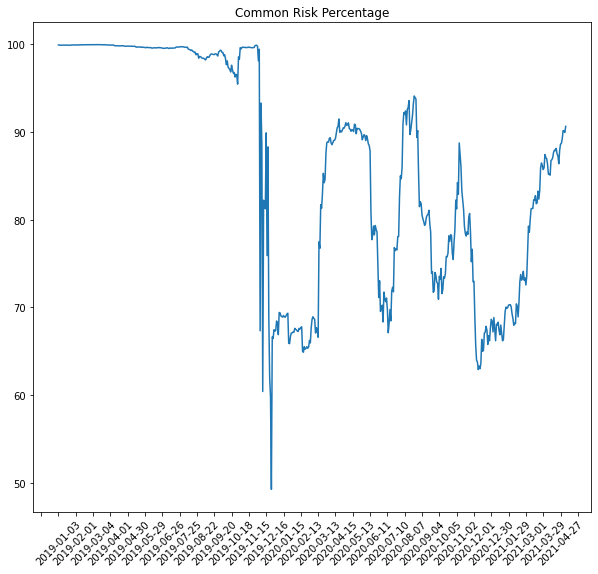

In [ ]:
common_pct = Sigma/(Sigma + Delta)*100.0

fig, ax = plt.subplots()
ax.plot(x, common_pct)
ax.xaxis.set_major_locator(plt.MaxNLocator(40))
ax.tick_params(axis='x', labelrotation = 45)
plt.title("Common Risk Percentage")
plt.show()

## Approach 2: Factor Value Normalization
With the other method, we calculate the coefficients $b_{ij}$ from the formula

$$ b_{ij} = \frac{\text{Value of factor for asset }i - \text{Average value of factor}}{\sigma(\text{Factor values})} $$
By scaling the value of the factor in this way, we make the coefficients comparable across factors. The exceptions to this formula are indicator variables, which are set to 1 for true and 0 for false. One example is industry membership: the coefficient tells us whether the asset belongs to the industry or not. After we calculate all of the coefficients, we estimate $F_j$ and $a_i$ using a cross-sectional regression (i.e. at each time step, we perform a regression using the equations for all of the assets).

Following this procedure, we get the cross-sectional returns on 2015-07-31, and compute the coefficients for all assets:

In [ ]:
import pandas as pd

data = pd.read_csv("/content/drive/MyDrive/finance_course/Projects/bbg.csv", index_col="Date")
#market = pd.read_csv("/content/drive/MyDrive/finance_course/Projects/market.csv", index_col="Date")

#market.drop(columns=['Open_SP500', 'High_SP500', 'Low_SP500', 'Close_SP500', 'Volume_SP500', 'Open_Rf', 'High_Rf', 'Low_Rf',
#            'Close_Rf', 'Volume_Rf'], inplace=True)
#data = data.join(market, on="Date")
data.drop(['Unnamed: 0'], axis=1, inplace=True)
print (data.head())
data.index = pd.to_datetime(data.index)

           ticker  Adj Close    return  CUR_MKT_CAP       BoP
Date                                                         
2019-01-03     GE  61.300621  0.001241   70106.8069  0.459411
2019-01-04     GE  62.593567  0.020873   71585.4864  0.449924
2019-01-07     GE  66.472382  0.060124   76021.5251  0.423675
2019-01-08     GE  65.103378 -0.020810   74455.8644  0.432582
2019-01-09     GE  64.647049 -0.007034   73933.9775  0.435635


In [ ]:
factor_labels = ['CUR_MKT_CAP', 'BoP']
std_labels = ['CUR_MKT_CAP_std', 'BoP_std']


tickers = data['ticker'].unique()
dfs = []
for t in tickers:
  temp = data[data['ticker'] == t].resample('w').mean()
  temp['ticker'] = [t] * len(temp)
  dfs.append(temp)

weekly = pd.concat(dfs)

factors = {}
for d in weekly.index:
  cs = weekly[weekly.index == d].copy()
  cs[std_labels] = (cs[factor_labels] - cs[factor_labels].mean())/cs[factor_labels].std()
  factors[d] = cs


In [ ]:
import statsmodels.api as sm
rres2 = []

for d in factors:
  mlr = sm.OLS(factors[d]['return'], sm.add_constant(factors[d][std_labels])).fit()
  #mlr.summary()
#  #print ('Sensitivities of {} returns:\n{}'.format(cs['ticker'].iloc[0], coeffs.iloc[0]))
#  #print ('\nFactors on {}:\n{}'.format(d, mlr.params[1:]))
  rres2.append(mlr.params)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


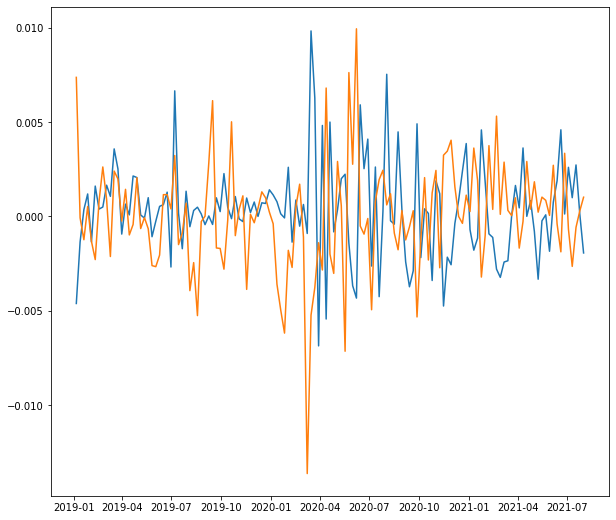

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams['figure.figsize'] = (10, 9)

rres2 = np.array(rres2)

plt.plot(list(factors.keys()), rres2[:, 1])
plt.plot(list(factors.keys()), rres2[:, 2])
plt.show()

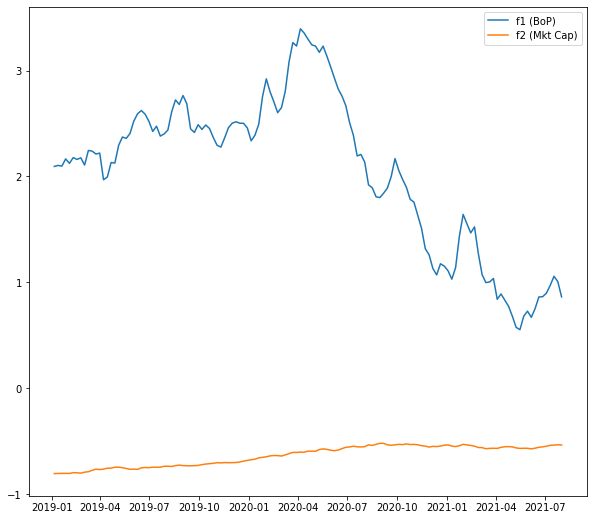

In [ ]:
from pandas import Timestamp

ticker = 'AA'
f1 = []
f2 = []
for d in factors:
  temp = factors[d]
  f2.append(temp['CUR_MKT_CAP_std'].loc[temp['ticker'] == ticker].values)  
  f1.append(temp['BoP_std'].loc[temp['ticker'] == ticker].values)  

plt.plot(list(factors.keys()), f1, label='f1 (BoP)')
plt.plot(list(factors.keys()), f2, label='f2 (Mkt Cap)')
plt.legend()
plt.show()


## Using Fundamental Factor Modeling Returns Prediction
As discussed in the Arbitrage Price Theory lecture, factor modeling can be used to predict future returns based on current fundamental factors, or to determine when an asset may be mispriced. Modeling future returns is accomplished by offsetting the returns in the regression, so that rather than predicted for current returns, you are predicting for future returns. Once you have a predictive model, the most canonical way to create a strategy is to attempt a long-short equity approach.

There will be a full lecture describing long-short equity, but the general idea is that you rank equities based on their predicted future returns. You then long the top p% and short the bottom p% remaining neutral on dollar volume. If the assets at the top of the ranking on average tend to make $5\%$ more per year than the market, and assets at the bottom tend to make $5\%$ less, then you will make $(M + 0.05) - (M - 0.05) = 0.10$ or $10\%$ percent per year, where $M$ is the market return that gets canceled out.

## Hedging out Exposure
Once we've determined that we are exposed to a factor, we may want to avoid depending on the performance of that factor by taking out a hedge. This is discussed in the Beta Hedging lecture and also in the Risk Factor Exposure notebook.